# Hénon–Heiles Hamiltoinan Dynamics

The (normalized) Hénon–Heiles Hamiltonian can be written as

$$
    H(\mathbf{q}, \mathbf{p}) = \frac{1}{2} (p_1^2 + p_2^2) + \frac{1}{2}(q_1^2 + q_2^2) + q_1^2 q_2 - \frac{1}{3} q_2^3.
$$

In this note, Poincaré map of this system is analyzed.

Here, a poincare section of surface (PSOS) $\Sigma^+$ is defined as follows:

$$
    \Sigma^+ = \left\{ (\mathbf{q}, \mathbf{p}) | q_1=0, p_1>0, H(\mathbf{q}, \mathbf{p})=E \right\},
$$
where $E$ is a total energy of this system.

---

## Potential energy surface of the Hénon–Heiles system

First, potential energy surface of the system is drawn.

By visualizing, we can grasp an overview of this system.

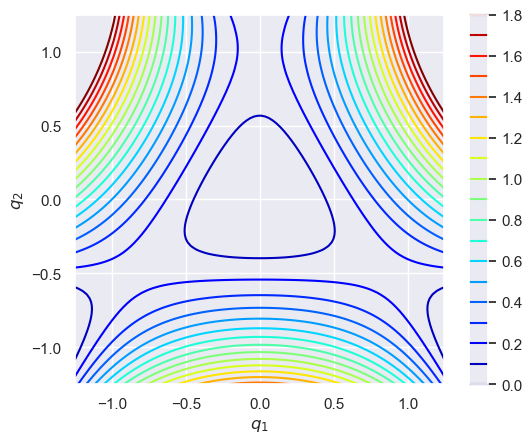

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Henon-Heiles potential
def V_xy(x, y):
    V = (x**2 + y**2) / 2 + (x**2) * y - (y**3) / 3
    return V

def plot_hh_2d():
    sns.set()
    x = np.linspace(-1.25, 1.25, 100)
    y = np.linspace(-1.25, 1.25, 100)
    X, Y = np.meshgrid(x, y)
    Z = V_xy(X, Y)

    fig, ax = plt.subplots()
    cont = ax.contour(X, Y, Z, np.linspace(0, 1.8, 19), cmap='jet')
    ax.set_aspect('equal','box')
    ax.set_xlabel("$q_1$")
    ax.set_ylabel("$q_2$")
    plt.colorbar(cont)
    plt.show()

plot_hh_2d()



---

## Initial condition sampling

In this note, initial conditions are sampled on the PSOS $\Sigma^+$.

That is, given $q_2$ and $p_2$, then $p_1 > 0$ is determined as a function of $(q_2, p_2)$

The equation of the PSOS is as follows:
$$
    E = \frac{1}{2} (p_1^2 + p_2^2) + \frac{1}{2}(q_2^2) - \frac{1}{3} q_2^3.
$$

Therefore, $p_1 > 0$ is derived as follows:
$$
    p_1 = \sqrt{2E - \left\{ p_2^2 + q_2^2 - \frac{2}{3} q_2^3 \right\}}.
$$

Note that the boundary of PSOS corresponds to $p_2=0$,
therefore the curve was described by the following equation:

$$
    p_2 = \pm \sqrt{2E - \left\{q_2^2 - \frac{2}{3} q_2^3 \right\} }.
$$
---

## Poincaré map of a trajectory

Next, Poincaré map of a trajectory is drawn.

Numerical integration is conducted by scipy.integrate.odeint.

Only initial $(q_2, p_2)$ should be given.

In [45]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import sympy

class HenonHeilesDynamics:
    """
    energy, n_trj
    calculate trajectory
    method:
    self.calc_n_trj_rk()
    """
    def __init__(self, total_energy, t_final=30, timestep=0.01):
        # total_energy
        self.E = total_energy
        # numerical integration step
        self.timestep = timestep
        # time term
        self.t_final = t_final
        # trajectory
        self.trj = 0
        

    def _func_ode(self, y, t):
        q1, p1, q2, p2 = y
        # simultaneous differential equations
        dq1dt = p1
        dp1dt = - q1 * (1 + 2*q2)
        dq2dt = p2
        dp2dt = - q2 * (1 - q2) - q1**2
        return dq1dt, dp1dt, dq2dt, dp2dt

    # Potential function of Henon-Heiles
    def _potential_func(self, q1, q2):
        V = (q1**2 + q2**2) / 2 + (q1**2)*q2 - (q2**3)/3
        return V

    # Hamiltonian of Henon-Heiles
    def _Hamiltonian(self, q1, p1, q2, p2):
        H = (p1**2 + p2**2) / 2 + self._potential_func(q1, q2)
        return H

    # initial condition preparation
    def _initial_condition_preparation(self, q2, p2, E):
        q1 = 0
        p1 = np.sqrt(2*E - (p2**2 + q2**2 - (2 * q2**3)/3 ))
        return [q1, p1, q2, p2]


    # a method to calculate trajectory
    def calc_trj(self, q2, p2):
        """
        input: qp_init = [q1, p1, q2, p2]
        output: trj = [[q1, p1, q2, p2], ...]
        """
        # initial condition preparation
        qp_init = self._initial_condition_preparation(q2, p2, self.E)
        # qp_trj: q, p along the trajectory
        qp_trj = odeint(self._func_ode, qp_init, np.arange(0, self.t_final, self.timestep))
        self.trj = qp_trj
        return qp_trj

    # a method to check the total energy is preserved or not
    def check_preserve_H(self, fig_path=0):
        fig = plt.figure(dpi=200)
        ax = fig.add_subplot(111)
        # transform _Hamiltonian to ufunc
        u_H = np.frompyfunc(self._Hamiltonian, 4, 1)

        trj = self.trj
        
        H_list = u_H(trj[:, 0], trj[:, 1], trj[:, 2], trj[:, 3])
        
        sns.set()

        ax.plot(list(range(len(H_list))), H_list)

        ax.set_ylim(((self.E-0.001), (self.E+0.001)))
        
        ax.set_xlabel('timestep')
        ax.set_ylabel('total energy')
        fig.tight_layout()
        if fig_path:
            plt.savefig(fig_path)
        else:
            plt.show()

    # plot trajectory on PES
    def trajectory_on_pes(self):
        x = np.linspace(-1.25, 1.25, 100)
        y = np.linspace(-1.25, 1.25, 100)
        X, Y = np.meshgrid(x, y)
        Z = self._potential_func(X, Y)

        # trj_calc = self.calc_1_trj()
        trj = self.trj

        print('length of trj is: {0}\ntotal time: {1}'.format(len(trj), (len(trj)*0.01)))

        sns.set()
        fig = plt.figure(dpi=200)
        # fig.set_aspect('equal')
        ax1 = fig.add_subplot(111)
        cont = ax1.contour(X, Y, Z, np.linspace(0, 1.8, 19), cmap='jet')
        ax1.scatter(trj[:, 0], trj[:, 2], s=1, color='black')
        # ax1.scatter(trj[0, 0], trj[0, 2], s=150, marker='*', color='tomato', label='initial point')
        # ax1.scatter(trj[-1, 0], trj[-1, 2], s=100, marker='^', color='tomato', label='terminal point')
        ax1.set_aspect('equal','box')
        ax1.set_xlim((-1.25, 1.25))
        ax1.set_ylim((-1.25, 1.25))
        ax1.set_xlabel('$q_1$')
        ax1.set_ylabel('$q_2$')
        ax1.set_title('A trajectory on PES')
        ax1.clabel(cont, inline=True, fontsize=10)
        # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.show()

In [61]:
class PoincareMap:
    """
    In this class, we calculate Poincare map for Henon-Heiles system.
    The Poincare section of surface is defined as q1=0, p1>0.
    """

    def __init__(self, total_energy, trj, calcboundary=True):
        self.E = total_energy
        self.trj = trj
        # for plot the energetic boundary
        if calcboundary:
            self._Q2, self._P2, self._curve = self._calc_boundary()

    # Potential function of Henon-Heiles
    def _potential_func(self, q1, q2):
        V = (q1**2 + q2**2) / 2 + (q1**2)*q2 - (q2**3)/3
        return V

    def _calc_boundary(self):
        """
        To calculate and draw energetically allowed region,
        useing matplotlib.contour() is a better way...
        It feels like there is a lot of inefficiency in this calculation, but...
        When we solve the equation of the boundary:
            p2 = \pm \sqrt( 2E - q2^2 + 2q2^3/3 ),
        then, it is difficult to draw a curve around the maximum and minimum of q2 (sparse).
        So, we plot the boundary as follows:
            q2range = np.arange(q2_min, q2_max, 0.01)
            p2range = np.arange(p2_min, p2_max, 0.01)
            Q2, P2 = np.meshgrid(q2range, p2range)
            curve = (Q2**2 + P2**2) / 2 - (Q2**3)/3 - E
        Then,
            ax.contour(Q2, P2, curve, [0], colors='black')
        """
        # calculate limit of q2
        q2_limit = self._calc_q2_limit()
        p2_limit = [-np.sqrt(2*self.E), np.sqrt(2*self.E)]

        # save limit of q2 and p2
        self._Q2_lim = q2_limit
        self._P2_lim = p2_limit

        q2range = np.arange(self._Q2_lim[0]-0.01, self._Q2_lim[1]+0.01, 0.01)
        p2range = np.arange(self._P2_lim[0]-0.01, self._P2_lim[1]+0.01, 0.01)
        Q2, P2 = np.meshgrid(q2range, p2range)
        curve = (Q2**2 + P2**2) / 2 - (Q2**3)/3 - self.E

        return Q2, P2, curve

    def _calc_q2_limit(self):
        """
        limit of q2 is calculated by solving the following equation:
            -2 * q2**3 + 3 * q2**2 - 6 * E = 0,
            where E is total energy and 0 < E < 1/6.
        This equation is solved by sympy.solve()
        """
        q2 = sympy.Symbol('q2')
        expr = -2 * q2**3 + 3 * q2**2 - 6 * self.E
        limit = sympy.solve(expr, q2)
        # to eliminate complex number due to numerical error
        re_limit = [sympy.re(l) for l in limit]
        return re_limit[:2]


    def calc_poincare_map(self):
        """
        input: self.trj = [[q1, p1, q2, p2], ...]
        output: poincare_map = [[q2, p2], ...]
        """
        poincare_map = []
        for i in range(len(self.trj)-1):
            # if p_1(i) > 0 and p_1(i+1) < 0
            if (self.trj[i, 0] < 0) and (self.trj[i+1, 0] > 0):
                # then calculate internal division point
                a = - self.trj[i, 0]
                b = self.trj[i+1, 0]
                qp_int = (b/(a+b))*self.trj[i, :] + (a/(a+b))*self.trj[i+1, :]
                poincare_map.append(qp_int[2:])
        self.qp_poincaremap = np.array(poincare_map)
        return np.array(poincare_map)

    def plot_poincare_map(self):

        sns.set()
        fig = plt.figure(dpi=200)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal','box')

        # plot boundary
        ax.contour(self._Q2, self._P2, self._curve, [0], colors='silver')

        # plot poincare map
        ax.scatter(self.qp_poincaremap[:, 0], self.qp_poincaremap[:, 1], s=1, color='black')

        ax.set_xlim(float(self._Q2_lim[0])-0.05, float(self._Q2_lim[1])+0.05)
        ax.set_ylim(float(self._P2_lim[0])-0.05, float(self._P2_lim[1])+0.05)

        ax.set_xlabel('$q_2$')
        ax.set_ylabel('$p_2$')
        ax.set_title('Poincaré map')
        plt.tight_layout()
        plt.show()

    def plot_trj_and_pm(self):
        """
            Plot trajectory and Poincare map on the same figure.
        """
        x = np.linspace(-1.25, 1.25, 100)
        y = np.linspace(-1.25, 1.25, 100)
        X, Y = np.meshgrid(x, y)
        Z = self._potential_func(X, Y)

        # trj_calc = self.calc_1_trj()
        sns.set()
        fig = plt.figure(dpi=200)
        ax1 = fig.add_subplot(121)
        cont = ax1.contour(X, Y, Z, np.linspace(0, 1.8, 19), cmap='jet')
        ax1.scatter(self.trj[:, 0], self.trj[:, 2], s=1, color='black')
        ax1.set_aspect('equal','box')
        ax1.set_xlim((-1.25, 1.25))
        ax1.set_ylim((-1.25, 1.25))
        ax1.set_xlabel('$q_1$')
        ax1.set_ylabel('$q_2$')
        ax1.set_title('A trajectory on PES')
        # ax1.clabel(cont, inline=True, fontsize=10)
        #
        # plot Poincare map
        ax2 = fig.add_subplot(122)
        ax2.set_aspect('equal','box')
        # plot boundary
        ax2.contour(self._Q2, self._P2, self._curve, [0], colors='silver')
        # plot poincare map
        ax2.scatter(self.qp_poincaremap[:, 0], self.qp_poincaremap[:, 1], s=1, color='black')
        ax2.set_xlim(float(self._Q2_lim[0])-0.05, float(self._Q2_lim[1])+0.05)
        ax2.set_ylim(float(self._P2_lim[0])-0.05, float(self._P2_lim[1])+0.05)
        ax2.set_xlabel('$q_2$')
        ax2.set_ylabel('$p_2$')
        ax2.set_title('Poincaré map of the trajectory')
        #
        # show
        plt.tight_layout()
        plt.show()



In [47]:
def get_poincaremap(total_energy, q2, p2, t_final=1000, timestep=0.01):
    """
    input:  
        total_energy: total energy of the system
        q2, p2: initial condition
        t_final: final time of the trajectory
        timestep: numerical integration step
    """
    # calculate the trajectory
    trajectory = HenonHeilesDynamics(total_energy=total_energy, t_final=t_final, timestep=timestep)
    trajectory.calc_trj(q2=q2, p2=p2)
    # calculate the Poincaré map of the trajectory
    poincaremap = PoincareMap(total_energy=total_energy, trj=trajectory.trj)
    poincaremap.calc_poincare_map()
    # show the Poincaré map of the trajectory
    poincaremap.plot_trj_and_pm()
    # delete the objects
    del trajectory, poincaremap

## Results

Below are the results of the following conditions.

For each condition, the trajectories on the potential surface is plotted on the left, 
and the Poincaré map of the trajectory is plotted on the right.

**Note**: 
- To calculate and plot Poincaré map of a trajectory, call the function `get_poincaremap()` with arguments q2, p2, E.
- You can also modify the simulation end time 't_final' and the time step for numerical integration 'timestep'.
- In the figure of the Poincaré map, outer gray curve show the energetically allowed region

### $E=1/12$, $(q_2, p_2) = (0, 0)$

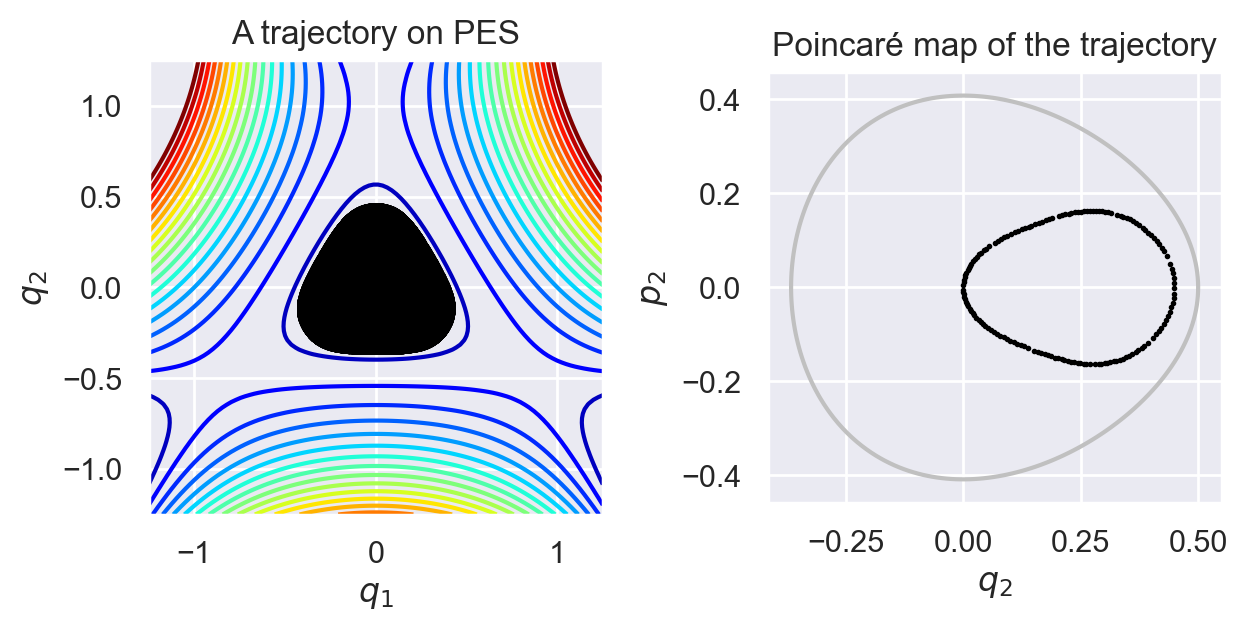

In [37]:
get_poincaremap(total_energy=1/12, q2=0, p2=0)

### $E=1/12$, $(q_2, p_2) = (0, 0.25)$

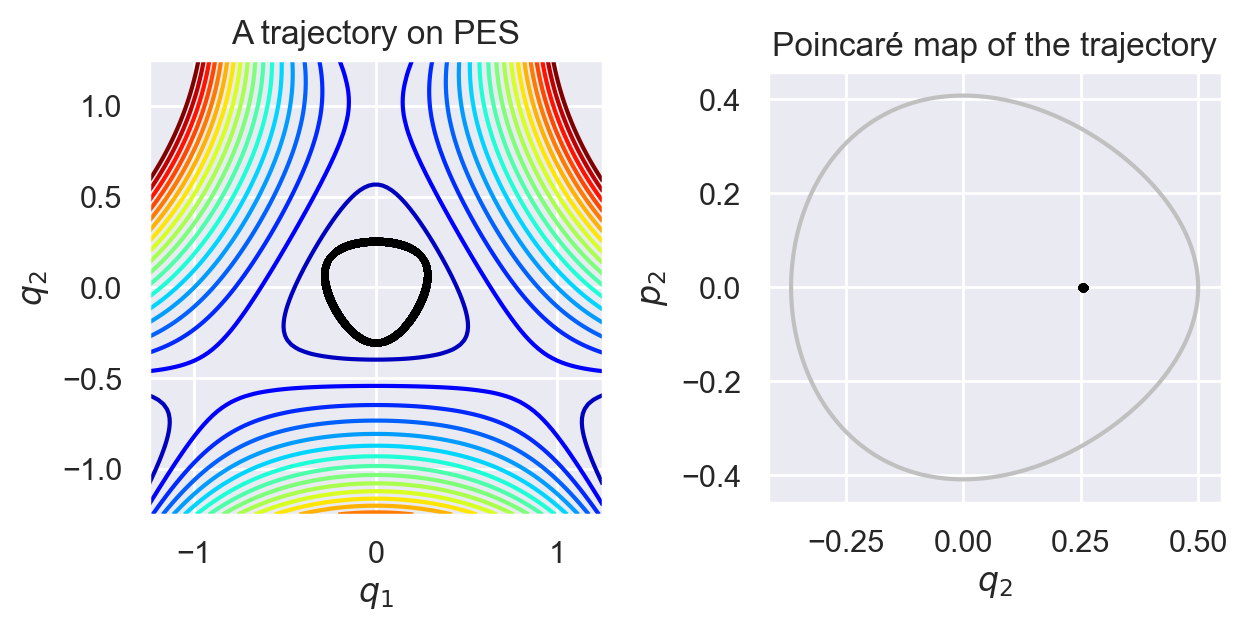

In [39]:
get_poincaremap(total_energy=1/12, q2=0.25, p2=0)

### $E=1/6$, $(q_2, p_2) = (0, 0)$

This is the chaotic condition.

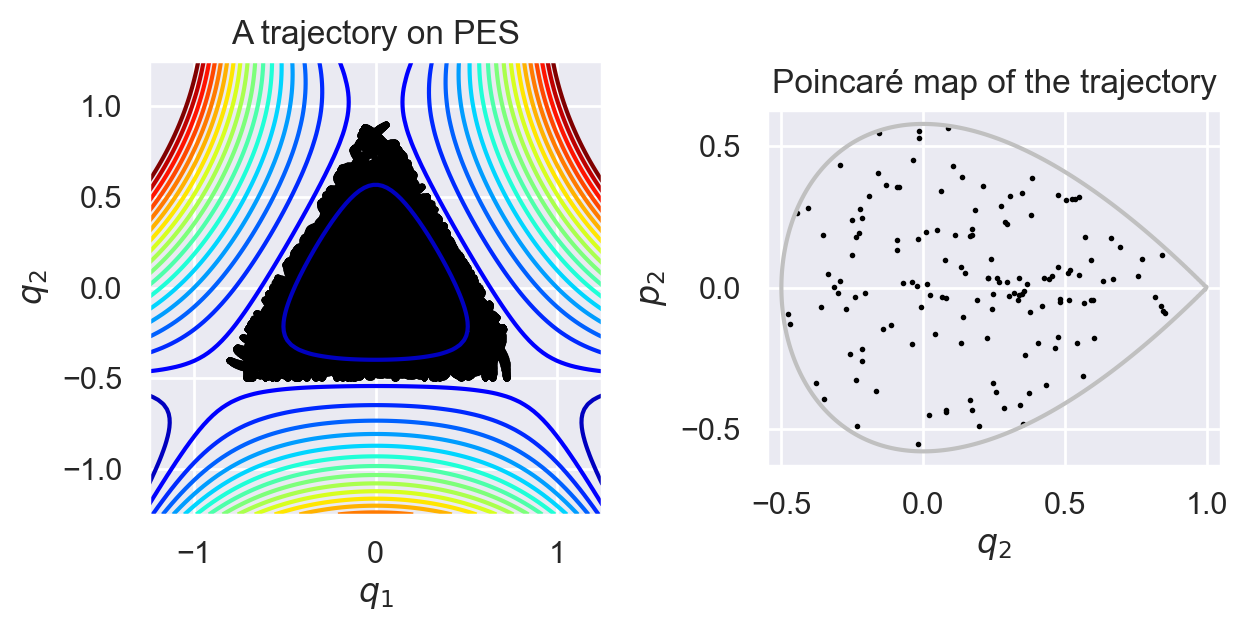

In [40]:
get_poincaremap(total_energy=1/6, q2=0, p2=0)

According to the figure above, the closed curve on Poincaré map corresponds to a trajectory.

---

## Multiple Poincaré maps

Run trajectories from multiple initial conditions, obtain Poincaré maps for each, and plot them all on a single figure.

In [52]:
def get_multple_poincaremap(total_energy, q2p2_list, t_final=1000, timestep=0.01):
    """
    input:
        total_energy: total energy of the system
        q2p2_list: list of initial conditions, [[q2, p2], ...]
        t_final: final time of the trajectory
        timestep: numerical integration step
    """
    # get the energetycally allowed boundary
    pm = PoincareMap(total_energy=total_energy, trj=0)
    Q2, P2, curve = pm._Q2, pm._P2, pm._curve
    #
    sns.set()
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111)
    ax.set_aspect('equal','box')
    # plot boundary
    ax.contour(Q2, P2, curve, [0], colors='silver')
    #
    # calculate poincarepaps
    for i in range(len(q2p2_list)):
        trajectory = HenonHeilesDynamics(total_energy=total_energy, t_final=t_final, timestep=timestep)
        trajectory.calc_trj(q2=q2p2_list[i][0], p2=q2p2_list[i][1])
        poincaremap = PoincareMap(total_energy=total_energy, trj=trajectory.trj, calcboundary=False)
        poincaremaparray =  poincaremap.calc_poincare_map()
        # plot
        ax.scatter(poincaremaparray[:, 0], poincaremaparray[:, 1], s=1, color='black')

    ax.set_xlim(float(pm._Q2_lim[0])-0.05, float(pm._Q2_lim[1])+0.05)
    ax.set_ylim(float(pm._P2_lim[0])-0.05, float(pm._P2_lim[1])+0.05)
    ax.set_xlabel('$q_2$')
    ax.set_ylabel('$p_2$')
    ax.set_title('Poincaré map of the trajectories')
    plt.tight_layout()
    plt.show()

In [73]:
# get the list [[q2, 0], [q2, 0], ...] and [[0, p2], [0, p2], ...]
def gen_qp_list(q2_min, q2_max, p2_min, p2_max, step):
    q2 = np.arange(q2_min, q2_max+step, step)
    p2 = np.arange(p2_min, p2_max+step, step)
    # [q2, 0]
    q2p20 = [[q, 0] for q in q2]
    # [0, p2]
    q20p2 = [[0, p] for p in p2]
    return q2p20, q20p2

### $E = 1/24$

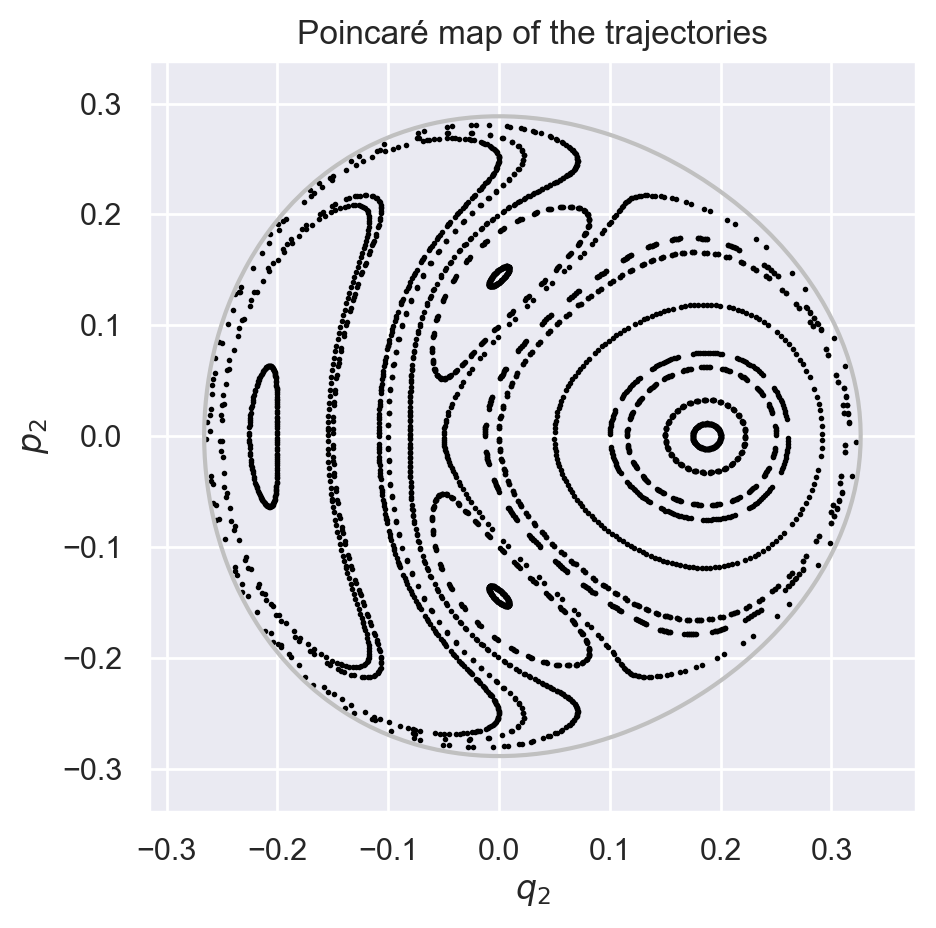

In [74]:
qp0_24, q0p_24 = gen_qp_list(-0.25, 0.25, -0.25, 0.25, 0.05)

get_multple_poincaremap(
    total_energy=1/24,
    q2p2_list=[
        # [q2, p2=0]
        *qp0_24,
        # [q2=0, p2]
        *q0p_24
        ]
)

### $E = 1/12$

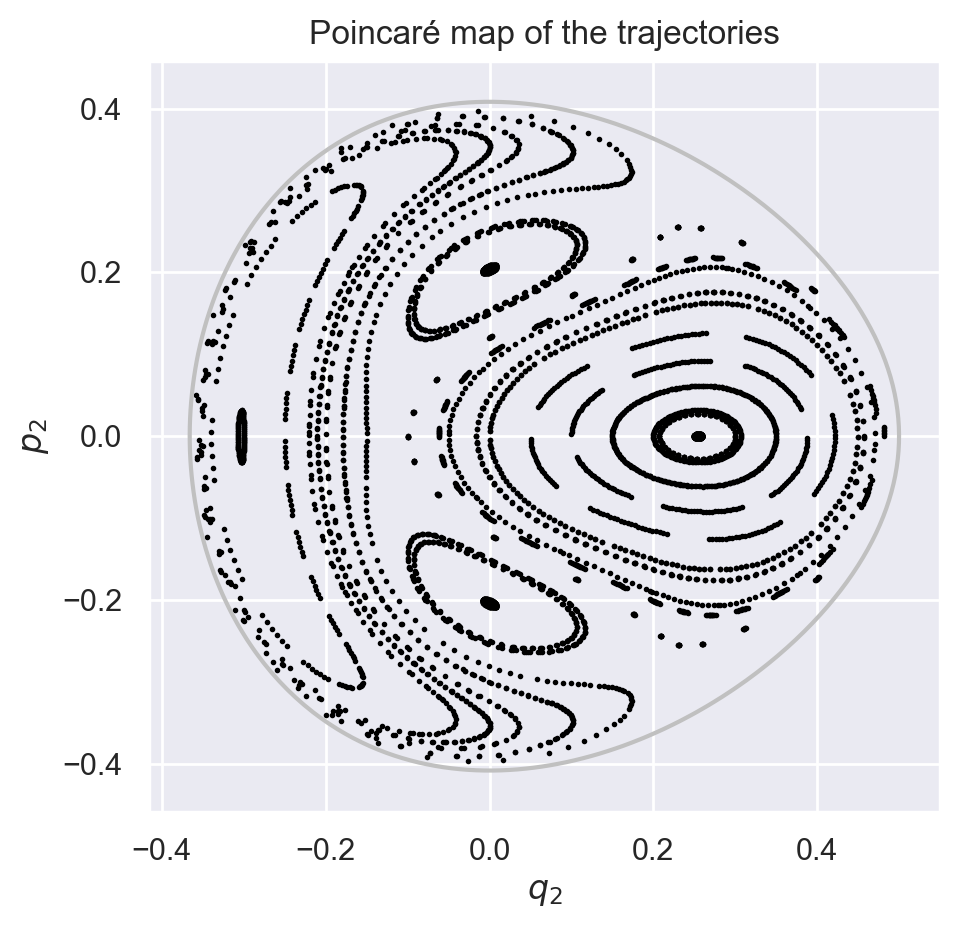

In [75]:
qp0_12, q0p_12 = gen_qp_list(-0.35, 0.35, -0.35, 0.35, 0.05)
get_multple_poincaremap(
    total_energy=1/12,
    q2p2_list=[
        # [q2, p2=0]
        *qp0_12,
        # [q2=0, p2]
        *q0p_12
        ]
)

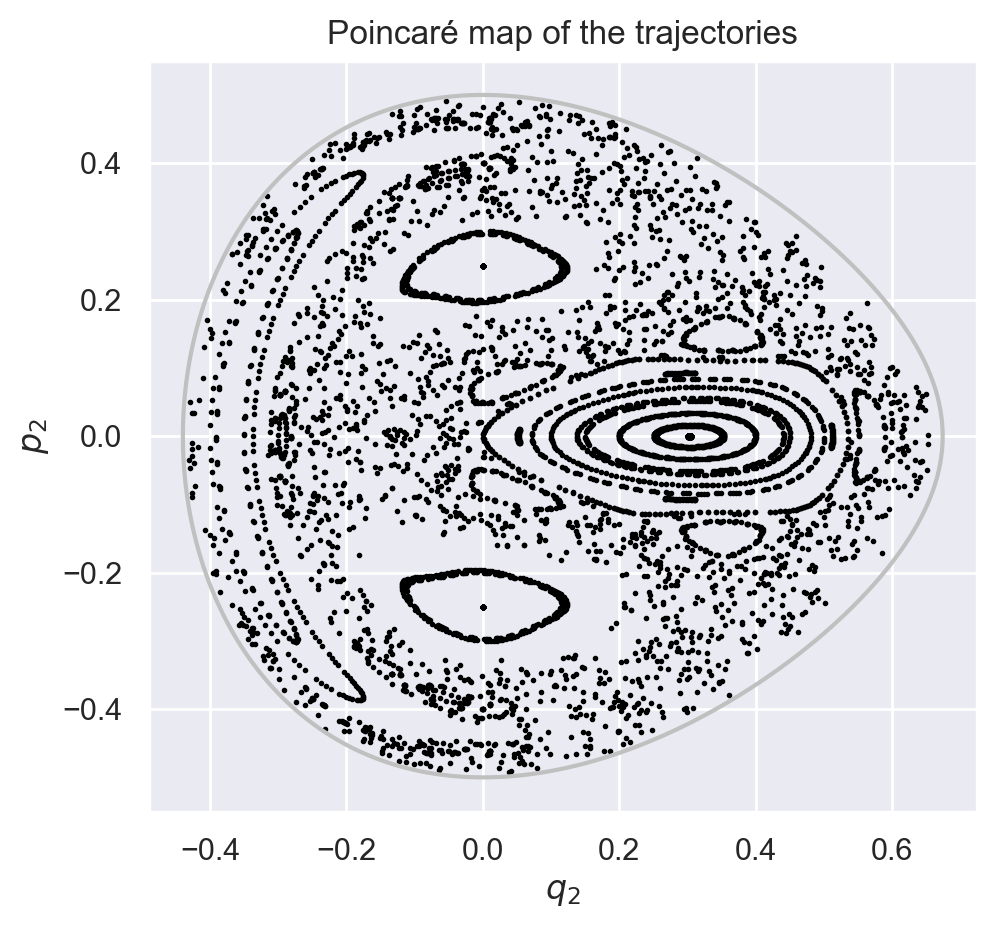

In [78]:
qp0_08, q0p_08 = gen_qp_list(-0.4, 0.65, -0.45, 0.45, 0.05)
get_multple_poincaremap(
    total_energy=1/8,
    q2p2_list=[
        # [q2, p2=0]
        *qp0_08,
        # [q2=0, p2]
        *q0p_08
        ]
)

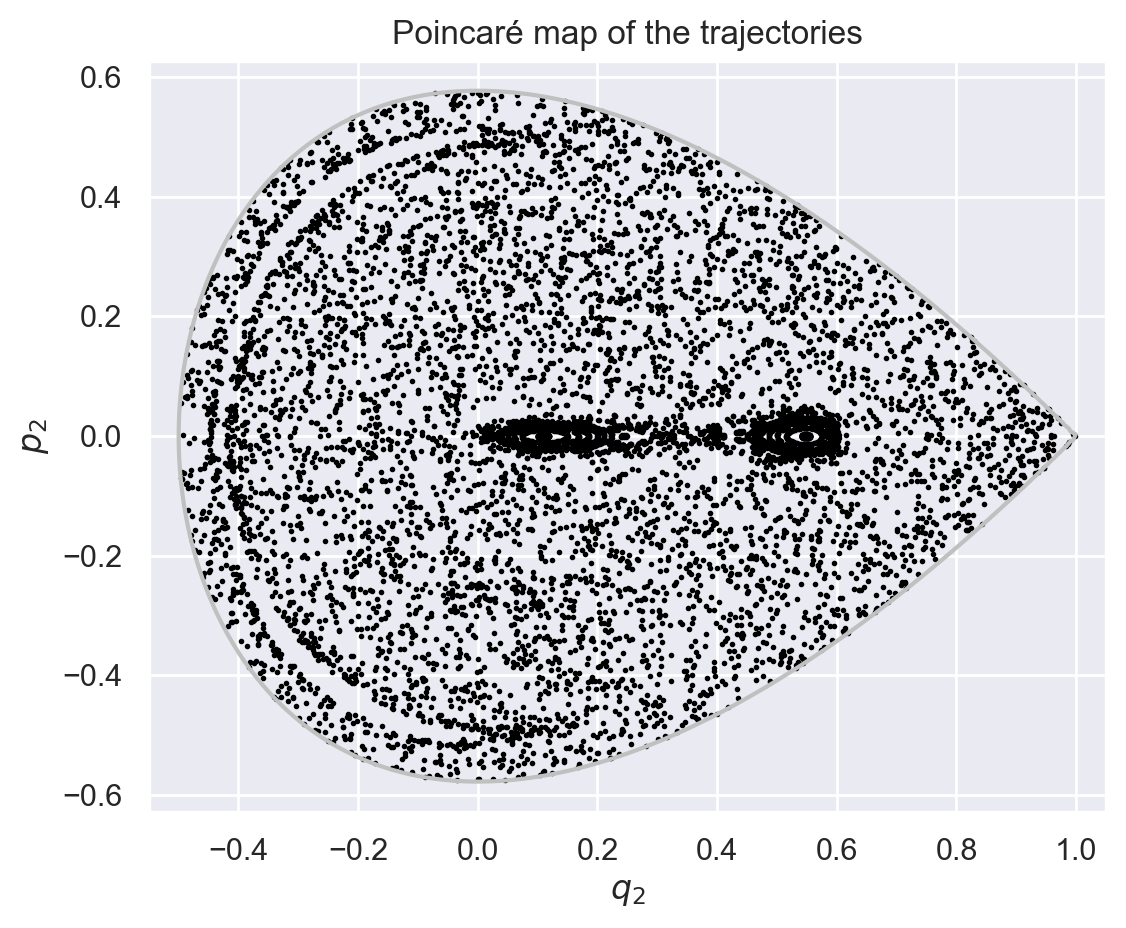

In [79]:
qp0_06, q0p_06 = gen_qp_list(-0.45, 0.95, -0.55, 0.55, 0.05)
get_multple_poincaremap(
    total_energy=1/6,
    q2p2_list=[
        # [q2, p2=0]
        *qp0_06,
        # [q2=0, p2]
        *q0p_06
        ]
)